In [1]:
import matplotlib.pyplot as plt
import numpy as np
import numpy.ma as ma
import netCDF4 as nc
import cmocean.cm as cm 
from IPython.display import display, Math, Latex
import matplotlib.gridspec as gridspec
import matplotlib.dates as mdates
from scipy.io import loadmat
from scipy.interpolate import griddata
from dateutil.parser import parse
from salishsea_tools import geo_tools, viz_tools, tidetools, nc_tools

%matplotlib inline
 

/home/ssahu/anaconda3/lib/python3.5/site-packages/xarray/conventions.py:9: FutureWarning: The pandas.tslib module is deprecated and will be removed in a future version.
  from pandas.tslib import OutOfBoundsDatetime


### 1) LOOK at THE SURFACE AND SHELF BREAK CURRENTS WITH THE WINDS DO THEY FOLLOW THE PHYSICS 

In [3]:
u_vel = nc.Dataset('/ocean/ssahu/CANYONS/Results/NEMO_trial_viscosity/viscosity_225_30_day_run/WCVI_1h_20160402_20160509_grid_U.nc')
v_vel = nc.Dataset('/ocean/ssahu/CANYONS/Results/NEMO_trial_viscosity/viscosity_225_30_day_run/WCVI_1h_20160402_20160509_grid_V.nc')
w_vel = nc.Dataset('/ocean/ssahu/CANYONS/Results/NEMO_trial_viscosity/viscosity_225_30_day_run/WCVI_1h_20160402_20160509_grid_W.nc')

bathy = '/ocean/ssahu/CANYONS/wcvi/grid/bathy_meter.nc'



ugrid = u_vel.variables['vozocrtx']
vgrid = v_vel.variables['vomecrty']
zlevels = u_vel.variables['depthu']
timesteps = u_vel.variables['time_counter']
lat = u_vel.variables['nav_lat']
lon = u_vel.variables['nav_lon']

In [4]:
diff_lat = np.ediff1d(lat)
diff_lon = np.ediff1d(lon)

In [5]:
np.max(diff_lon)

0.081245422

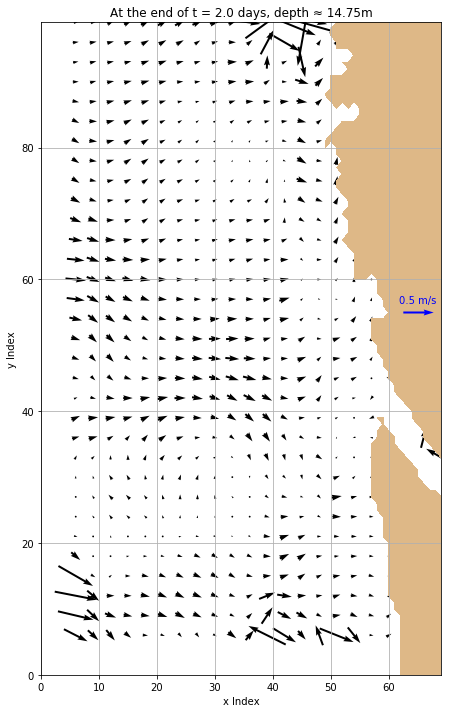

In [6]:
# Define the slice to plot
t, zlevel = 47 , 0
y_slice = np.arange(0, 100)
x_slice = np.arange(0, 70)
# Slice and mask the arrays
ugrid_tzyx = np.ma.masked_values(ugrid[t, zlevel, y_slice, x_slice], 0)
vgrid_tzyx = np.ma.masked_values(vgrid[t, zlevel, y_slice, x_slice], 0)
# "Unstagger" the velocity values by interpolating them to the T-grid points
u_tzyx, v_tzyx = viz_tools.unstagger(ugrid_tzyx, vgrid_tzyx)
speeds = np.sqrt(np.square(u_tzyx) + np.square(v_tzyx))


arrow_step = 3
y_slice_a = y_slice[::arrow_step]
x_slice_a = x_slice[::arrow_step]


# Plot the velocity vectors
fig, ax = plt.subplots(1, 1, figsize=(16, 12))
viz_tools.set_aspect(ax)
quiver = ax.quiver(x_slice_a[1:], y_slice_a[1:], u_tzyx[::3,::3], v_tzyx[::3,::3] ,pivot='mid', cmap='Reds', width=0.005)
viz_tools.plot_land_mask(ax, bathy , xslice=x_slice, yslice=y_slice, color='burlywood')
# Axes limits and grid
ax.set_xlim(x_slice[0], x_slice[-1])
ax.set_ylim(y_slice[0], y_slice[-1])
ax.grid()
# Axes label and title
ax.set_xlabel('x Index')
ax.set_ylabel('y Index')
ax.set_title('At the end of t = {0} days, depth \u2248 {d:.2f}{z.units}'.format((t+1)/24, d=zlevels[zlevel], z=zlevels))
ax.quiverkey(quiver, 65, 55, 0.5, '0.5 m/s', coordinates='data', color='blue', labelcolor='blue')

### We observe high velocities at the north east and south west corners (at the surface of the ocean) which means they are the barotropic wave speed

We also observed some reflected barotropic waves at the south east corner of our domain

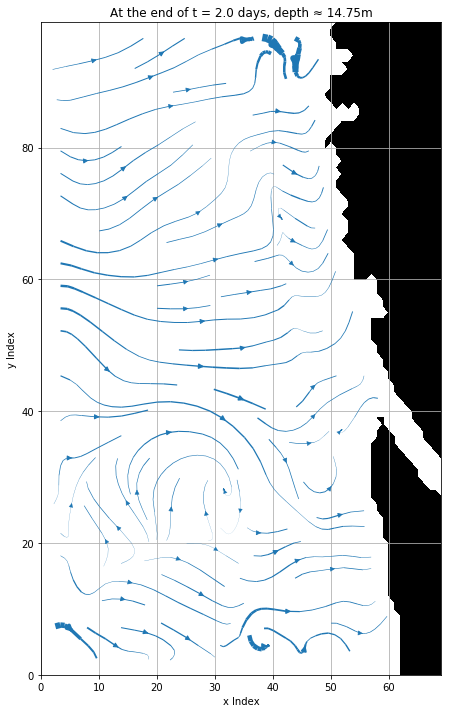

In [7]:
t, zlevel = 47, 0
y_slice = np.arange(0, 100)
x_slice = np.arange(0, 70)

ugrid_tzyx = np.ma.masked_values(ugrid[t, zlevel, y_slice, x_slice], 0)
vgrid_tzyx = np.ma.masked_values(vgrid[t, zlevel, y_slice, x_slice], 0)
u_tzyx, v_tzyx = viz_tools.unstagger(ugrid_tzyx, vgrid_tzyx)
speeds = np.sqrt(np.square(u_tzyx) + np.square(v_tzyx))
max_speed = viz_tools.calc_abs_max(speeds)

fig, ax = plt.subplots(1, 1, figsize=(16, 12))
viz_tools.set_aspect(ax)

ax.streamplot(
    x_slice[1:], y_slice[1:], u_tzyx, v_tzyx,
    linewidth=10*speeds/max_speed,
)
viz_tools.plot_land_mask(ax, bathy, xslice=x_slice, yslice=y_slice)

ax.set_xlim(x_slice[0], x_slice[-1])
ax.set_ylim(y_slice[0], y_slice[-1])
ax.grid()

ax.set_xlabel('x Index')
ax.set_ylabel('y Index')
ax.set_title('At the end of t = {0} days, depth \u2248 {d:.2f}{z.units}'.format((t+1)/24, d=zlevels[zlevel], z=zlevels))

In [8]:
bdy_file = nc.Dataset('/ocean/ssahu/CANYONS/bdy_files/2d_west_flather_twoless_m04.nc')


u_bdy = bdy_file.variables['vobtcrtx'][:]
v_bdy = bdy_file.variables['vobtcrty'][:]


print(np.max(v_bdy) ,np.max(u_bdy))

0.173412 0.173412


### This means the high velocities are not from the West boundary condition

### Let us look for the winds on this day (we see a downwelling pattern on this day)

End of 2nd day means 3rd April Completed and 4th April starting (our run starts from 2nd April)

In [9]:
import numpy as np
import xarray as xr
import pickle
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.dates as mdates
from scipy.io import loadmat
from scipy.interpolate import griddata
from dateutil.parser import parse
from salishsea_tools import geo_tools, viz_tools, tidetools, nc_tools

%matplotlib inline

In [11]:
# plt.rcParams['font.size'] = 12


In [12]:
# def reshape_grid(tmask, gridX, gridY):
    
#     ngrid = tmask.shape[0] * tmask.shape[1]
#     tmask = tmask.reshape(ngrid)
#     ngrid_water = tmask.sum()
#     gridX = gridX.reshape(ngrid)[tmask]
#     gridY = gridY.reshape(ngrid)[tmask]
    
#     return tmask, gridX, gridY, ngrid, ngrid_water

In [13]:
# # Get mask and grid files
# mask = xr.open_dataset('/ocean/ssahu/CANYONS/Results/NEMO_trial_viscosity/viscosity_225_30_day_run/mesh_mask.nc')

# # Mask
# tmask = mask.tmask.isel(t=0).values.astype(bool)
# tmask[:, 750:, :] = 0
# tmask[:, :350, :] = 0
# tmask[:, :, :100] = 0

# # Grid
# gridX, gridY = np.meshgrid(mask.x, mask.y)

# # Full Grid Surface
# tmask_full = tmask[0, :, :]
# ngrid = tmask_full.shape[0] * tmask_full.shape[1]
# tmask_full = tmask_full.reshape(ngrid)
# ngrid_water = tmask_full.sum()
# gridX_full = gridX.reshape(ngrid)[tmask_full]
# gridY_full = gridY.reshape(ngrid)[tmask_full]

# # Sub Grid Surface
# tmask_sub_0 = tmask[0, ::5, ::5]
# nsubgrid = tmask_sub_0.shape[0] * tmask_sub_0.shape[1]
# tmask_sub_0 = tmask_sub_0.reshape(nsubgrid)
# nsubgrid_water_0 = tmask_sub_0.sum()
# gridX_sub_0 = gridX[::5, ::5].reshape(nsubgrid)[tmask_sub_0]
# gridY_sub_0 = gridY[::5, ::5].reshape(nsubgrid)[tmask_sub_0]

# # Sub Grid 20 m
# tmask_sub_10 = tmask[18, ::5, ::5].reshape(nsubgrid)
# nsubgrid_water_10 = tmask_sub_10.sum()
# gridX_sub_10 = gridX[::5, ::5].reshape(nsubgrid)[tmask_sub_10]
# gridY_sub_10 = gridY[::5, ::5].reshape(nsubgrid)[tmask_sub_10]

# # Depth
# deptht = mask.gdept_0.isel(t=0).values
# deptht = deptht.reshape(-1, ngrid)[:, tmask_full]
# dz = np.diff(deptht, axis=0)

In [14]:
# /

In [15]:
# # Timerange
# timerange = ['2016 Apr 03 00:00', '2016 Apr 04 23:00']
# timeslice = slice(timerange[0], timerange[1])

# # Load Wind
# wind = xr.open_dataset('https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSaSurfaceAtmosphereFieldsV1')
# u_wind = wind.sel(time=timeslice).u_wind.values.reshape(-1, ngrid_GEM)
# v_wind = wind.sel(time=timeslice).v_wind.values.reshape(-1, ngrid_GEM)
# u_wind_trim = np.zeros((u_wind.shape[0], ngrid_GEM_water))
# v_wind_trim = np.zeros((v_wind.shape[0], ngrid_GEM_water))
# for tindex, timerows in enumerate(zip(u_wind, v_wind)):
#     u_wind_trim[tindex, :] = timerows[0][mask_GEM]
#     v_wind_trim[tindex, :] = timerows[1][mask_GEM]
# GEM = {
#     'u_wind': u_wind_trim,
#     'v_wind': v_wind_trim
# }

In [16]:
# u_wind_trim.shape

In [17]:
# v_wind_trim.shape

In [18]:
# plt.pcolormesh(u_wind_trim)

In [19]:
# plt.barbs(u_wind,v_wind)

In [10]:
atmos_forcing_file = nc.Dataset('/ocean/ssahu/CANYONS/nemo-forcing/43_days_JP_primitive/ops_y2016m04d03.nc')
bathy = '/ocean/ssahu/CANYONS/wcvi/grid/bathy_meter.nc'



u_wind = atmos_forcing_file.variables['u_wind']
v_wind = atmos_forcing_file.variables['v_wind']
timesteps =u_wind.shape[0]

bathy_file = nc.Dataset(bathy)

lon = bathy_file.variables['nav_lon'][:]
lat = bathy_file.variables['nav_lat'][:]


X = lon.flatten()
Y = lat.flatten()

points = (X[:],Y[:])

big_lon_atmos = atmos_forcing_file.variables['nav_lon'][:]

big_lon = np.empty_like(big_lon_atmos)
big_lon[:] = big_lon_atmos[:] - 360

big_lat = atmos_forcing_file.variables['nav_lat'][:]

X_big = big_lon.flatten()
Y_big = big_lat.flatten()

xi = (X_big[:],Y_big[:])

interp_wind_u = np.empty((u_wind.shape[0], lon.shape[0], lon.shape[1]))
interp_wind_v = np.empty_like(interp_wind_u)

for i in np.arange(u_wind.shape[0]):
    interp_wind_u[i,...] = np.reshape(griddata(xi, u_wind[i,...].flatten(), points, method= 'linear'), lon.shape)
    interp_wind_v[i,...] = np.reshape(griddata(xi, v_wind[i,...].flatten(), points, method= 'linear'), lon.shape)




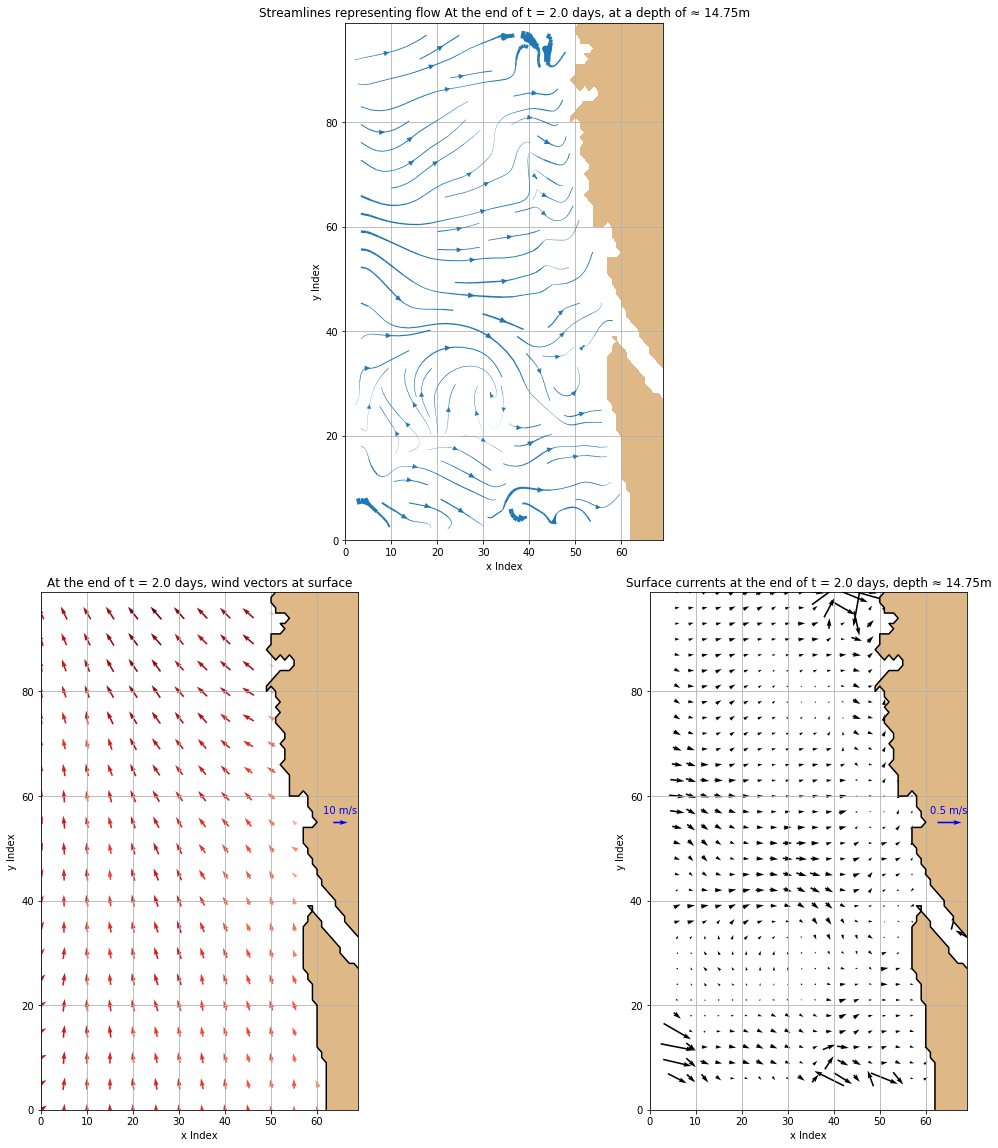

In [11]:
y_slice = np.arange(0, 100)
x_slice = np.arange(0, 70)
t = 23


ax = [0, 0, 0]
# date_NW = parse('2016 May 7 12:00')
# date_SE = parse('2016 Oct 15 12:00')

fig = plt.figure(figsize=(20, 20))

gs = gridspec.GridSpec(2, 2)
gs.update(hspace=0.1)

ax[0] = plt.subplot(gs[0,:])
ax[1] = plt.subplot(gs[1:, 0])
ax[2] = plt.subplot(gs[1:, 1])
# Slice and mask the arrays
# ugrid_tzyx = np.ma.masked_values(interp_wind_u[:, :], 0)
# vgrid_tzyx = np.ma.masked_values(interp_wind_v[:, :], 0)
# "Unstagger" the velocity values by interpolating them to the T-grid points
u_tzyx_wind, v_tzyx_wind = viz_tools.unstagger(interp_wind_u[t,...], interp_wind_v[t,...])
speeds_wind = np.sqrt(np.square(u_tzyx_wind) + np.square(v_tzyx_wind))


arrow_step = 5
y_slice_a = y_slice[::arrow_step]
x_slice_a = x_slice[::arrow_step]


X,Y = np.meshgrid(x_slice_a,y_slice_a)

# Plot the velocity vectors

# fig, ax = plt.subplots(1, 1, figsize=(16, 12))
viz_tools.set_aspect(ax[1])
quiver = ax[1].quiver(X, Y, u_tzyx_wind[::arrow_step,::arrow_step], v_tzyx_wind[::arrow_step,::arrow_step], speeds_wind[::arrow_step,::arrow_step] ,pivot='mid', cmap='Reds', width=0.005)
viz_tools.plot_land_mask(ax[1], bathy , xslice=x_slice, yslice=y_slice, color='burlywood')
viz_tools.plot_coastline(ax[1], bathy)

# Axes limits and grid
ax[1].set_xlim(x_slice[0], x_slice[-1])
ax[1].set_ylim(y_slice[0], y_slice[-1])
ax[1].grid()
# Axes label and title
ax[1].set_xlabel('x Index')
ax[1].set_ylabel('y Index')
ax[1].set_title('At the end of t = {0} days, wind vectors at surface'.format((t+1+24)/24))
ax[1].quiverkey(quiver, 65, 55, 10, '10 m/s', coordinates='data', color='blue', labelcolor='blue')


# Define the slice to plot
zlevel =  0

# Slice and mask the arrays
ugrid_tzyx = np.ma.masked_values(ugrid[t+24, zlevel, y_slice, x_slice], 0)
vgrid_tzyx = np.ma.masked_values(vgrid[t+24, zlevel, y_slice, x_slice], 0)
# "Unstagger" the velocity values by interpolating them to the T-grid points
u_tzyx, v_tzyx = viz_tools.unstagger(ugrid_tzyx, vgrid_tzyx)
speeds = np.sqrt(np.square(u_tzyx) + np.square(v_tzyx))


arrow_step = 3
y_slice_a = y_slice[::arrow_step]
x_slice_a = x_slice[::arrow_step]


# Plot the velocity vectors
# fig, ax[1] = plt.subplots(1, 1, figsize=(16, 12))
viz_tools.set_aspect(ax[2])
quiver = ax[2].quiver(x_slice_a[1:], y_slice_a[1:], u_tzyx[::3,::3], v_tzyx[::3,::3] ,pivot='mid', cmap='Reds', width=0.005)
viz_tools.plot_land_mask(ax[2], bathy , xslice=x_slice, yslice=y_slice, color='burlywood')
viz_tools.plot_coastline(ax[2], bathy)
# Axes limits and grid
ax[2].set_xlim(x_slice[0], x_slice[-1])
ax[2].set_ylim(y_slice[0], y_slice[-1])
ax[2].grid()
# Axes label and title
ax[2].set_xlabel('x Index')
ax[2].set_ylabel('y Index')
ax[2].set_title('Surface currents at the end of t = {0} days, depth \u2248 {d:.2f}{z.units}'.format((t+1+24)/24, d=zlevels[zlevel], z=zlevels))
ax[2].quiverkey(quiver, 65, 55, 0.5, '0.5 m/s', coordinates='data', color='blue', labelcolor='blue')



viz_tools.set_aspect(ax[0])

ax[0].streamplot(
    x_slice[1:], y_slice[1:], u_tzyx, v_tzyx,
    linewidth=10*speeds/max_speed,
)
viz_tools.plot_land_mask(ax[0], bathy, xslice=x_slice, yslice=y_slice, color='burlywood')

ax[0].set_xlim(x_slice[0], x_slice[-1])
ax[0].set_ylim(y_slice[0], y_slice[-1])
ax[0].grid()

ax[0].set_xlabel('x Index')
ax[0].set_ylabel('y Index')
ax[0].set_title('Streamlines representing flow At the end of t = {0} days, at a depth of \u2248 {d:.2f}{z.units}'.format((t+1+24)/24, d=zlevels[zlevel], z=zlevels))

####  1)  can you go below the Ekman layer (say 50 m) and see what's going on there.  Is a current starting to flow south?

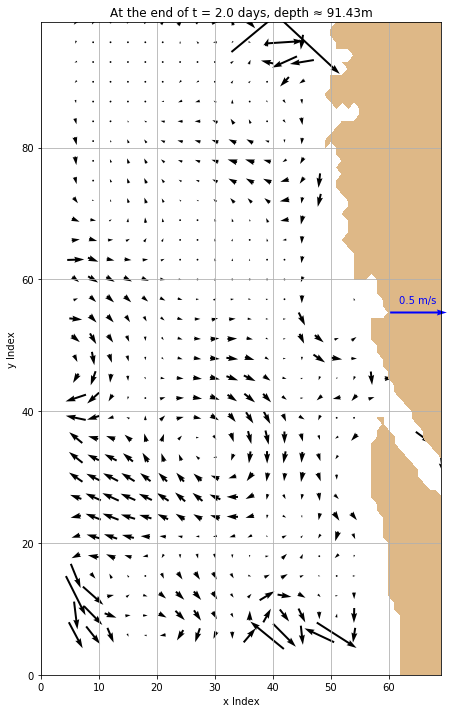

In [12]:
# Define the slice to plot
t, zlevel = 47 , 6
y_slice = np.arange(0, 100)
x_slice = np.arange(0, 70)
# Slice and mask the arrays
ugrid_tzyx = np.ma.masked_values(ugrid[t, zlevel, y_slice, x_slice], 0)
vgrid_tzyx = np.ma.masked_values(vgrid[t, zlevel, y_slice, x_slice], 0)
# "Unstagger" the velocity values by interpolating them to the T-grid points
u_tzyx, v_tzyx = viz_tools.unstagger(ugrid_tzyx, vgrid_tzyx)
speeds = np.sqrt(np.square(u_tzyx) + np.square(v_tzyx))


arrow_step = 3
y_slice_a = y_slice[::arrow_step]
x_slice_a = x_slice[::arrow_step]


# Plot the velocity vectors
fig, ax = plt.subplots(1, 1, figsize=(16, 12))
viz_tools.set_aspect(ax)
quiver = ax.quiver(x_slice_a[1:], y_slice_a[1:], u_tzyx[::3,::3], v_tzyx[::3,::3] ,pivot='mid', cmap='Reds', width=0.005)
viz_tools.plot_land_mask(ax, bathy , xslice=x_slice, yslice=y_slice, color='burlywood')
# Axes limits and grid
ax.set_xlim(x_slice[0], x_slice[-1])
ax.set_ylim(y_slice[0], y_slice[-1])
ax.grid()
# Axes label and title
ax.set_xlabel('x Index')
ax.set_ylabel('y Index')
ax.set_title('At the end of t = {0} days, depth \u2248 {d:.2f}{z.units}'.format((t+1)/24, d=zlevels[zlevel], z=zlevels))
ax.quiverkey(quiver, 65, 55, 0.5, '0.5 m/s', coordinates='data', color='blue', labelcolor='blue')

<a list of 1 text.Text objects>

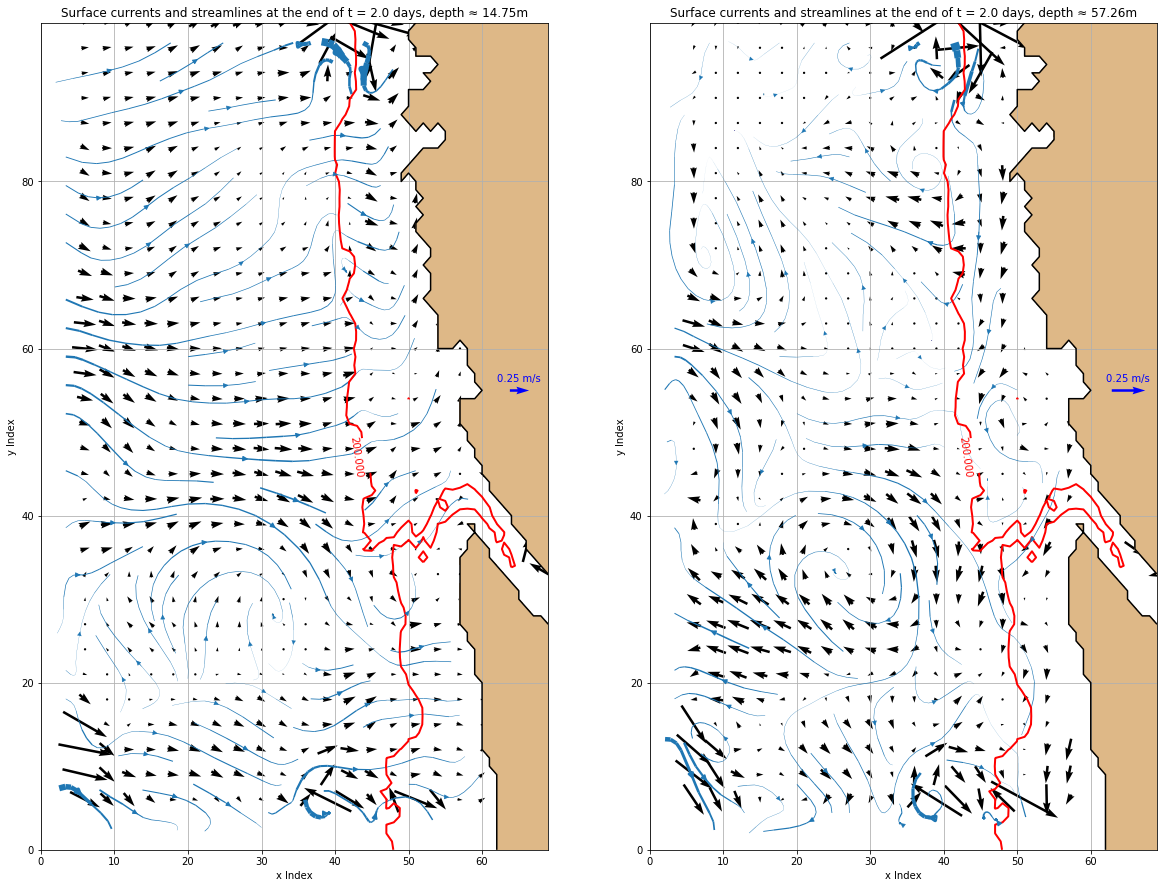

In [13]:
bathy = '/ocean/ssahu/CANYONS/wcvi/grid/bathy_meter.nc'

bathymetry = nc.Dataset(bathy).variables['Bathymetry'][:]

y_slice = np.arange(0, 100)
x_slice = np.arange(0, 70)
t = [0, 47]


ax = [0, 0]
# date_NW = parse('2016 May 7 12:00')
# date_SE = parse('2016 Oct 15 12:00')

fig = plt.figure(figsize=(20, 20))

gs = gridspec.GridSpec(2, 2)
gs.update(hspace=0.1)

# ax[3] = plt.subplot(gs[0:, 1])
ax[1] = plt.subplot(gs[0:, 1])
# ax[2] = plt.subplot(gs[1:, 1])
ax[0] = plt.subplot(gs[0:, 0])
# Slice and mask the arrays
# ugrid_tzyx = np.ma.masked_values(interp_wind_u[:, :], 0)
# vgrid_tzyx = np.ma.masked_values(interp_wind_v[:, :], 0)
# "Unstagger" the velocity values by interpolating them to the T-grid points


# Plot the velocity vectors




# Define the slice to plot
zlevel =  [0, 4]

# Slice and mask the arrays
ugrid_tzyx = np.ma.masked_values(ugrid[t[1], zlevel[0], y_slice, x_slice], 0)
vgrid_tzyx = np.ma.masked_values(vgrid[t[1], zlevel[0], y_slice, x_slice], 0)
# "Unstagger" the velocity values by interpolating them to the T-grid points
u_tzyx, v_tzyx = viz_tools.unstagger(ugrid_tzyx, vgrid_tzyx)
speeds = np.sqrt(np.square(u_tzyx) + np.square(v_tzyx))


arrow_step = 3
y_slice_a = y_slice[::arrow_step]
x_slice_a = x_slice[::arrow_step]


# Plot the velocity vectors
# fig, ax[1] = plt.subplots(1, 1, figsize=(16, 12))
viz_tools.set_aspect(ax[0])
quiver = ax[0].quiver(x_slice_a[1:], y_slice_a[1:], u_tzyx[::3,::3], v_tzyx[::3,::3] ,pivot='mid', cmap='Reds', width=0.005)
viz_tools.plot_land_mask(ax[0], bathy , xslice=x_slice, yslice=y_slice, color='burlywood')
viz_tools.plot_coastline(ax[0], bathy)
# Axes limits and grid
ax[0].set_xlim(x_slice[0], x_slice[-1])
ax[0].set_ylim(y_slice[0], y_slice[-1])
ax[0].grid()
# Axes label and title
ax[0].set_xlabel('x Index')
ax[0].set_ylabel('y Index')
ax[0].set_title('Surface currents and streamlines at the end of t = {0} days, depth \u2248 {d:.2f}{z.units}'.format((t[1]+1)/24, d=zlevels[zlevel[0]], z=zlevels))
ax[0].quiverkey(quiver, 65, 55, 0.25, '0.25 m/s', coordinates='data', color='blue', labelcolor='blue')

max_speed = viz_tools.calc_abs_max(speeds)

viz_tools.set_aspect(ax[0])

ax[0].streamplot(
    x_slice[1:], y_slice[1:], u_tzyx, v_tzyx,
    linewidth=10*speeds/max_speed,
)
viz_tools.plot_land_mask(ax[0], bathy, xslice=x_slice, yslice=y_slice, color='burlywood')


CS = ax[0].contour(x_slice,y_slice,bathymetry, levels = [200],
                 colors=('red',),linestyles=('-',),linewidths=(2,))


ax[0].clabel(CS)



# Slice and mask the arrays
ugrid_tzyx = np.ma.masked_values(ugrid[t[1], zlevel[1], y_slice, x_slice], 0)
vgrid_tzyx = np.ma.masked_values(vgrid[t[1], zlevel[1], y_slice, x_slice], 0)
# "Unstagger" the velocity values by interpolating them to the T-grid points
u_tzyx, v_tzyx = viz_tools.unstagger(ugrid_tzyx, vgrid_tzyx)
speeds = np.sqrt(np.square(u_tzyx) + np.square(v_tzyx))


arrow_step = 3
y_slice_a = y_slice[::arrow_step]
x_slice_a = x_slice[::arrow_step]


# Plot the velocity vectors
# fig, ax[1] = plt.subplots(1, 1, figsize=(16, 12))
viz_tools.set_aspect(ax[1])
quiver = ax[1].quiver(x_slice_a[1:], y_slice_a[1:], u_tzyx[::3,::3], v_tzyx[::3,::3] ,pivot='mid', cmap='Reds', width=0.005)
viz_tools.plot_land_mask(ax[1], bathy , xslice=x_slice, yslice=y_slice, color='burlywood')
viz_tools.plot_coastline(ax[1], bathy)
# Axes limits and grid
ax[1].set_xlim(x_slice[0], x_slice[-1])
ax[1].set_ylim(y_slice[0], y_slice[-1])
ax[1].grid()
# Axes label and title
ax[1].set_xlabel('x Index')
ax[1].set_ylabel('y Index')
ax[1].set_title('Surface currents and streamlines at the end of t = {0} days, depth \u2248 {d:.2f}{z.units}'.format((t[1]+1)/24, d=zlevels[zlevel[1]], z=zlevels))
ax[1].quiverkey(quiver, 65, 55, 0.25, '0.25 m/s', coordinates='data', color='blue', labelcolor='blue')

max_speed = viz_tools.calc_abs_max(speeds)

viz_tools.set_aspect(ax[1])

ax[1].streamplot(
    x_slice[1:], y_slice[1:], u_tzyx, v_tzyx,
    linewidth=10*speeds/max_speed,
)
viz_tools.plot_land_mask(ax[1], bathy, xslice=x_slice, yslice=y_slice, color='burlywood')



CS = ax[1].contour(x_slice,y_slice,bathymetry, levels = [200],
                 colors=('red',),linestyles=('-',),linewidths=(2,))


ax[1].clabel(CS)



# ax[0].set_xlim(x_slice[0], x_slice[-1])
# ax[0].set_ylim(y_slice[0], y_slice[-1])
# ax[0].grid()

# ax[0].set_xlabel('x Index')
# ax[0].set_ylabel('y Index')
# ax[0].set_title('Streamlines representing flow At the end of t = {0} days, at a depth of \u2248 {d:.2f}{z.units}'.format((t+1+24)/24, d=zlevels[zlevel], z=zlevels))


# max_speed = viz_tools.calc_abs_max(speeds)

# viz_tools.set_aspect(ax[3])

# ax[3].streamplot(
#     x_slice[1:], y_slice[1:], u_tzyx, v_tzyx,
#     linewidth=10*speeds/max_speed,
# )
# viz_tools.plot_land_mask(ax[0], bathy, xslice=x_slice, yslice=y_slice, color='burlywood')

# ax[3].set_xlim(x_slice[0], x_slice[-1])
# ax[3].set_ylim(y_slice[0], y_slice[-1])
# ax[3].grid()

# ax[3].set_xlabel('x Index')
# ax[3].set_ylabel('y Index')
# ax[3].set_title('Streamlines representing flow At the end of t = {0} days, at a depth of \u2248 {d:.2f}{z.units}'.format(t[0], d=zlevels[zlevel[0]], z=zlevels))

# # Slice and mask the arrays
# ugrid_tzyx = np.ma.masked_values(ugrid[t[0], zlevel[1], y_slice, x_slice], 0)
# vgrid_tzyx = np.ma.masked_values(vgrid[t[0], zlevel[1], y_slice, x_slice], 0)
# # "Unstagger" the velocity values by interpolating them to the T-grid points
# u_tzyx, v_tzyx = viz_tools.unstagger(ugrid_tzyx, vgrid_tzyx)
# speeds = np.sqrt(np.square(u_tzyx) + np.square(v_tzyx))


# arrow_step = 3
# y_slice_a = y_slice[::arrow_step]
# x_slice_a = x_slice[::arrow_step]


# # Plot the velocity vectors
# # fig, ax[1] = plt.subplots(1, 1, figsize=(16, 12))
# viz_tools.set_aspect(ax[2])
# quiver = ax[2].quiver(x_slice_a[1:], y_slice_a[1:], u_tzyx[::3,::3], v_tzyx[::3,::3] ,pivot='mid', cmap='Reds', width=0.005)
# viz_tools.plot_land_mask(ax[2], bathy , xslice=x_slice, yslice=y_slice, color='burlywood')
# viz_tools.plot_coastline(ax[2], bathy)
# # Axes limits and grid
# ax[2].set_xlim(x_slice[0], x_slice[-1])
# ax[2].set_ylim(y_slice[0], y_slice[-1])
# ax[2].grid()
# # Axes label and title
# ax[2].set_xlabel('x Index')
# ax[2].set_ylabel('y Index')
# ax[2].set_title('Surface currents at the end of t = {0} days, depth \u2248 {d:.2f}{z.units}'.format(t[1], d=zlevels[zlevel[1]], z=zlevels))
# ax[2].quiverkey(quiver, 65, 55, 0.5, '0.5 m/s', coordinates='data', color='blue', labelcolor='blue')


# max_speed = viz_tools.calc_abs_max(speeds)

# viz_tools.set_aspect(ax[0])

# ax[0].streamplot(
#     x_slice[1:], y_slice[1:], u_tzyx, v_tzyx,
#     linewidth=10*speeds/max_speed,
# )
# viz_tools.plot_land_mask(ax[0], bathy, xslice=x_slice, yslice=y_slice, color='burlywood')

# ax[0].set_xlim(x_slice[0], x_slice[-1])
# ax[0].set_ylim(y_slice[0], y_slice[-1])
# ax[0].grid()

# ax[0].set_xlabel('x Index')
# ax[0].set_ylabel('y Index')
# ax[0].set_title('Streamlines representing flow At the end of t = {0} days, at a depth of \u2248 {d:.2f}{z.units}'.format((t+1+24)/24, d=zlevels[zlevel], z=zlevels))




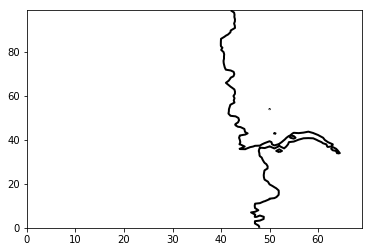

In [14]:
X,Y = np.meshgrid(x_slice,y_slice)

plt.contour(x_slice,y_slice,bathymetry, levels = [200],
                 colors=('k',),linestyles=('-',),linewidths=(2,))


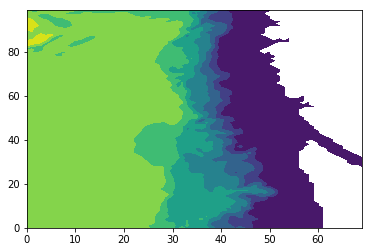

In [35]:
plt.contourf(bathymetry)

In [37]:
np.max(bathymetry)

3030.0

### 2) If you do a vertical slice perpendicular to the coast, say near Barkley Sound, can you see the isopycnals downwell ? 

In [15]:
tracers = nc.Dataset('/ocean/ssahu/CANYONS/Results/NEMO_trial_viscosity/viscosity_225_30_day_run/WCVI_1h_20160402_20160509_grid_T.nc')

lats = tracers.variables['nav_lat'][:]
lons = tracers.variables['nav_lon'][:]
sal = tracers.variables['vosaline'][:]
zlevels    = tracers.variables['deptht'][:]

/home/ssahu/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:7: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.


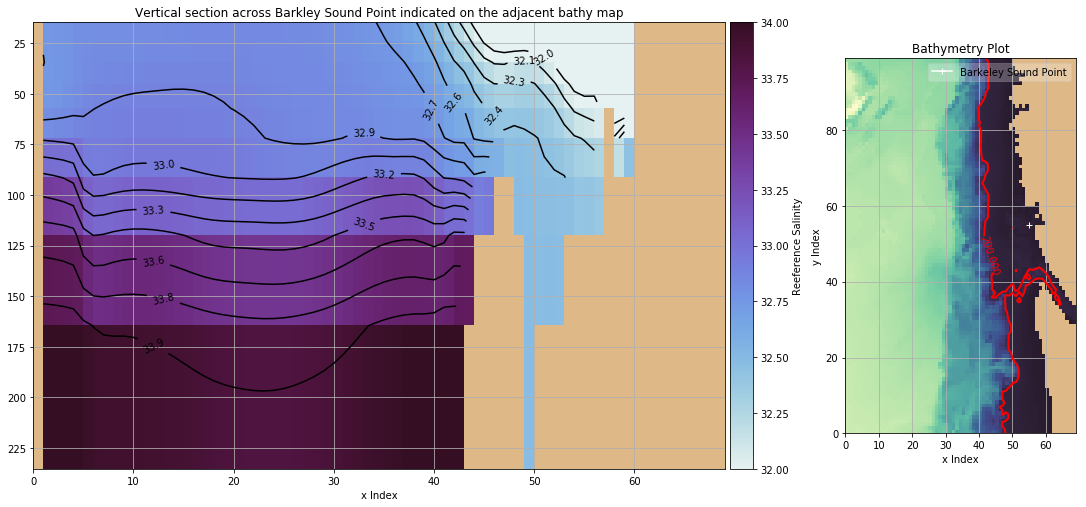

In [16]:


# Set up the figure and axes
fig, (axl, axcb, axr) = plt.subplots(1, 3, figsize=(16, 8))
land_colour = 'burlywood'
for ax in (axl, axr):
    ax.set_axis_bgcolor(land_colour)
axl.set_position((0.125, 0.125, 0.6, 0.775))
axcb.set_position((0.73, 0.125, 0.02, 0.775))
axr.set_position((0.83, 0.125, 0.2, 0.775))

# Plot thalweg points on bathymetry map
viz_tools.set_aspect(axr)
cmap = plt.get_cmap(cm.deep_r)
cmap.set_bad(land_colour)
# bathy = bathymetry
# x_slice = np.arange(bathy.shape[1])
# y_slice = np.arange(bathy.shape[0])
axr.pcolormesh(x_slice, y_slice, bathymetry, cmap=cmap)
axr.plot(
    x_slice[55], y_slice[55],
    linestyle='-', marker='+', color='white',
    label='Barkeley Sound Point',
)
legend = axr.legend(loc='best', fancybox=True, framealpha=0.25)
axr.set_title('Bathymetry Plot')
axr.set_xlabel('x Index')
axr.set_ylabel('y Index')
CS = axr.contour(x_slice,y_slice,bathymetry, levels = [200],
                 colors=('red',),linestyles=('-',),linewidths=(2,))


axr.clabel(CS)
axr.grid()

# Plot 24h average salinity at all depths along thalweg line
t = 47 
cmap = plt.get_cmap(cm.dense)
cmap.set_bad(land_colour)
sal_0 = sal[t, :10, :,:]
sal_tzyx = np.ma.masked_values(sal_0, 0)
x, z = np.meshgrid(x_slice, zlevels[:10])
mesh = axl.pcolormesh(x_slice, zlevels[:10], sal_tzyx[:10,55,x_slice], cmap=cmap, vmin=32, vmax=34)
cbar = plt.colorbar(mesh, cax=axcb)
cbar.set_label('Reeference Salinity')
clines = axl.contour(x_slice, zlevels[:10], sal_tzyx[:10,55,x_slice], np.arange(32, 34, 0.15), colors='black')
axl.clabel(clines, fmt='%1.1f', inline=True)
axl.invert_yaxis()
axl.set_xlabel('x Index')
# axl.set_ylabel('{0.long_name} [{0.units}]'.format(zlevels))
axl.grid()
axl.set_title('Vertical section across Barkley Sound Point indicated on the adjacent bathy map')

/home/ssahu/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:7: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.


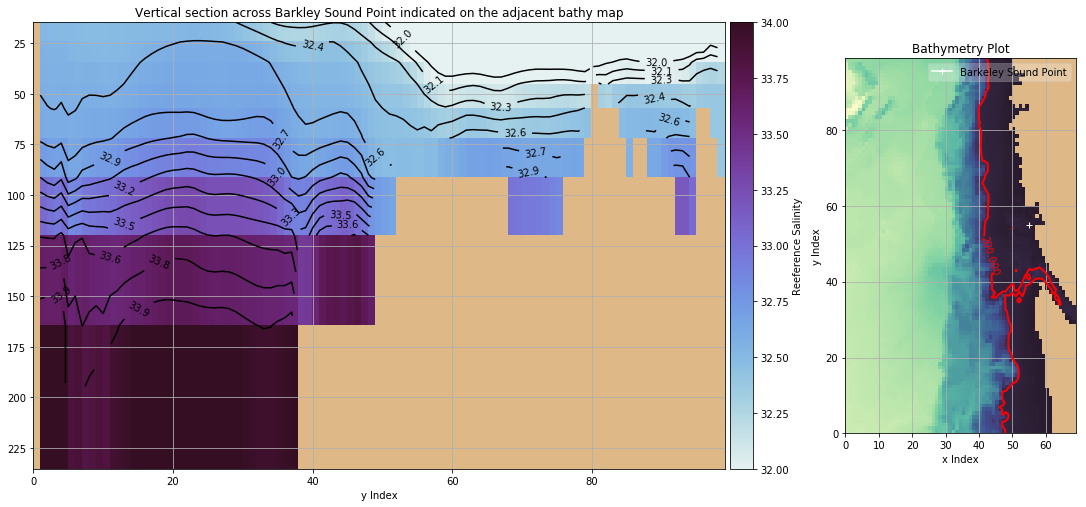

In [19]:


# Set up the figure and axes
fig, (axl, axcb, axr) = plt.subplots(1, 3, figsize=(16, 8))
land_colour = 'burlywood'
for ax in (axl, axr):
    ax.set_axis_bgcolor(land_colour)
axl.set_position((0.125, 0.125, 0.6, 0.775))
axcb.set_position((0.73, 0.125, 0.02, 0.775))
axr.set_position((0.83, 0.125, 0.2, 0.775))

# Plot thalweg points on bathymetry map
viz_tools.set_aspect(axr)
cmap = plt.get_cmap(cm.deep_r)
cmap.set_bad(land_colour)
# bathy = bathymetry
# x_slice = np.arange(bathy.shape[1])
# y_slice = np.arange(bathy.shape[0])
axr.pcolormesh(x_slice, y_slice, bathymetry, cmap=cmap)
axr.plot(
    x_slice[55], y_slice[55],
    linestyle='-', marker='+', color='white',
    label='Barkeley Sound Point',
)
legend = axr.legend(loc='best', fancybox=True, framealpha=0.25)
axr.set_title('Bathymetry Plot')
axr.set_xlabel('x Index')
axr.set_ylabel('y Index')
CS = axr.contour(x_slice,y_slice,bathymetry, levels = [200],
                 colors=('red',),linestyles=('-',),linewidths=(2,))


axr.clabel(CS)
axr.grid()

# Plot 24h average salinity at all depths along thalweg line
t = 47 
cmap = plt.get_cmap(cm.dense)
cmap.set_bad(land_colour)
sal_0 = sal[t, :10, :,:]
sal_tzyx = np.ma.masked_values(sal_0, 0)
x, z = np.meshgrid(x_slice, zlevels[:10])
mesh = axl.pcolormesh(y_slice, zlevels[:10], sal_tzyx[:10,y_slice,47], cmap=cmap, vmin=32, vmax=34)
cbar = plt.colorbar(mesh, cax=axcb)
cbar.set_label('Reeference Salinity')
clines = axl.contour(y_slice, zlevels[:10], sal_tzyx[:10,y_slice,47], np.arange(32, 34, 0.15), colors='black')
axl.clabel(clines, fmt='%1.1f', inline=True)
axl.invert_yaxis()
axl.set_xlabel('y Index')
# axl.set_ylabel('{0.long_name} [{0.units}]'.format(zlevels))
axl.grid()
axl.set_title('Vertical section across constant ')

3d Visualisations

In [43]:
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt

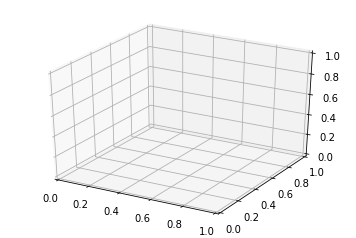

In [44]:
fig = plt.figure()
ax = plt.axes(projection='3d')

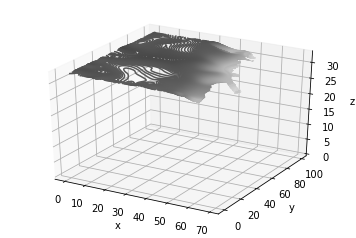

In [61]:
X,Y = np.meshgrid(x_slice,y_slice)

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.contour3D(X, Y, sal_tzyx[0,...],500, cmap='binary',vmin = 30, vmax =34)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z');

In [54]:
mask_file = nc.Dataset('/ocean/ssahu/CANYONS/Results/NEMO_trial_viscosity/viscosity_225_30_day_run/mesh_mask.nc')

In [55]:
nc_tools.show_variables(mask_file)

odict_keys(['nav_lon', 'nav_lat', 'nav_lev', 'time_counter', 'tmask', 'umask', 'vmask', 'fmask', 'tmaskutil', 'umaskutil', 'vmaskutil', 'fmaskutil', 'glamt', 'glamu', 'glamv', 'glamf', 'gphit', 'gphiu', 'gphiv', 'gphif', 'e1t', 'e1u', 'e1v', 'e1f', 'e2t', 'e2u', 'e2v', 'e2f', 'ff', 'mbathy', 'misf', 'isfdraft', 'e3t_0', 'e3u_0', 'e3v_0', 'e3w_0', 'gdept_0', 'gdepu', 'gdepv', 'gdepw_0', 'gdept_1d', 'gdepw_1d', 'e3t_1d', 'e3w_1d'])


In [56]:
tmask = mask_file.variables['tmask'][:]

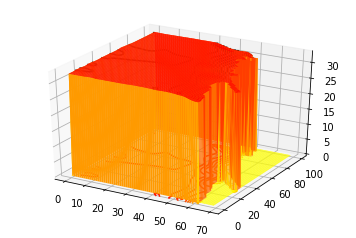

odict_keys(['xbT', 'yb', 'time_counter', 'sossheig', 'vobtcrtx', 'vobtcrty'])
